In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import shutil
import os
import random
import cv2
import math
import json
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


import keras
from keras.preprocessing.image import *
from keras.models import Sequential, Model
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Cropping2D, AveragePooling2D,BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from IPython.display import display # Allows the use of display() for DataFrames

# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_dir = 'data'
columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv(data_dir + '/driving_log.csv', header=None, names=columns)
data.iloc[:5]

,center,left,right,steering_angle,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
print("Data loaded...")
print("Dataset Columns:", columns, "\n")
print("Shape of the dataset:", data.shape, "\n")
print(data.describe(), "\n")

Data loaded...
Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

Shape of the dataset: (8036, 7) 

       steering_angle     throttle        brake        speed
count     8036.000000  8036.000000  8036.000000  8036.000000
mean         0.004070     0.869660     0.001970    28.169839
std          0.128840     0.301326     0.036565     6.149327
min         -0.942695     0.000000     0.000000     0.502490
25%          0.000000     0.985533     0.000000    30.183093
50%          0.000000     0.985533     0.000000    30.186400
75%          0.000000     0.985533     0.000000    30.186640
max          1.000000     0.985533     1.000000    30.709360 



(160, 320, 3)


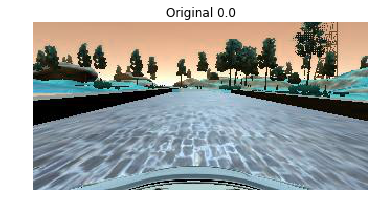

In [4]:
def read_image(file):
    # Readimage from file
    image = cv2.imread('data/' + file)
    return image

def showImage(image, title):
    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.title(title)
    plt.imshow(image)
    plt.show()

image = read_image(data['center'][0].strip())
print(image.shape)

showImage(image, 'Original ' + str(data['steering_angle'][0]) ) 

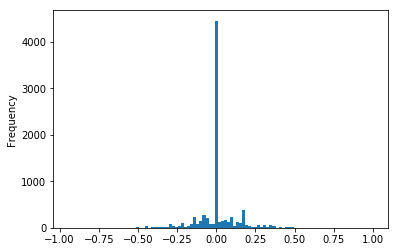

In [5]:
data['steering_angle'].plot.hist(bins=100)

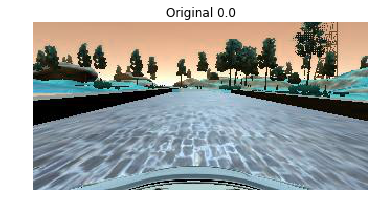

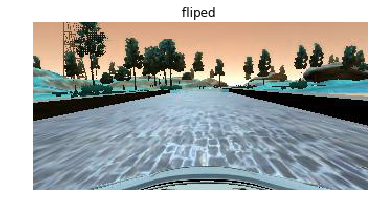

In [6]:
# flip images horizontally
def horizontal_flip(img):
    flipped_image = cv2.flip(img, 1)
    return flipped_image

showImage(image, 'Original ' + str(data['steering_angle'][0]) ) 
image = horizontal_flip(image)
showImage(image, 'fliped ')


In [7]:
CAMARA_ANGLE = 0.3


def preprozess_line(line_data):
    x, y = [], []
    y_steer = line_data['steering_angle']
    path_center = line_data['center'].strip()
    path_left = line_data['left'].strip()
    path_right = line_data['right'].strip()

    for path, shift in [(path_center, 0), (path_left, CAMARA_ANGLE), (path_right, -CAMARA_ANGLE)]:
        # read image
        image_path = os.path.join(data_dir, path)
        image = cv2.imread(image_path)

        # add image
        x.append(image)
        y.append(y_steer + shift)

        # add flipped image
        image = horizontal_flip(image)
        x.append(image)
        y.append(-(y_steer + shift))

    return np.array(x).astype('float32'), np.array(y).astype('float32')

line_data = data.iloc[0]
X_gen, Y_gen = preprozess_line(line_data)


In [8]:
# Number of training examples
n_X_gen = len(X_gen)

# Number of testing examples.
n_Y_gen = len(Y_gen)

# What's the shape of an traffic sign image?
image_shape = X_gen[0].shape

print("Number of line images =", n_X_gen)
print("Number of line labels =", n_Y_gen)
print("Image data shape =", image_shape)

Number of line images = 6
Number of line labels = 6
Image data shape = (160, 320, 3)


In [9]:
data_train, data_val = train_test_split(data, test_size=0.02)

In [10]:
MODEL_IMG_CHANNELS = 3

def nvidia_model(summary=False):
    model = Sequential()
    
    model = Sequential()
    # Crop the sky and bottom pixels, normalise and reduce dimensionality
    model.add(Cropping2D(((80,25),(1,1)), input_shape=[160, 320, 3], name="Crop2D"))
    model.add(BatchNormalization(axis=1, name="Normalise"))
    model.add(AveragePooling2D(pool_size=(1,4), name="Resize", trainable=False))

    # Successively learn through multiple convolutions, relu activations and pooling layers,
    model.add(Convolution2D(24, (3, 3), strides=(2,2), name="Conv1", activation="relu"))
    model.add(MaxPooling2D(name="MaxPool1"))
    model.add(Convolution2D(48, (3, 3), strides=(1,1), name="Conv2", activation="relu"))
    model.add(MaxPooling2D(name="MaxPool2"))
    model.add(Convolution2D(72, (3, 3), strides=(1,1), name="Conv3", activation="relu"))
    model.add(MaxPooling2D(name="MaxPool3"))
    model.add(Dropout(0.2, name="Dropout1"))

    # Learn the steering angles through 3 fully connected layers
    model.add(Flatten(name="Flatten"))
    model.add(Dense(100, activation="relu", name="FC2"))
    model.add(Dropout(0.5, name="Dropout2"))

    model.add(Dense(50, activation="relu", name="FC3"))
    model.add(Dropout(0.5, name="Dropout3"))

    model.add(Dense(10, activation="relu", name="FC4"))
    model.add(Dropout(0.5, name="Dropout4"))

    # Final Output  of steering angles
    model.add(Dense(1, name="Steering", activation='linear'))


    if summary:
        model.summary()
    return model


model = nvidia_model(True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Crop2D (Cropping2D)          (None, 55, 318, 3)        0         
_________________________________________________________________
Normalise (BatchNormalizatio (None, 55, 318, 3)        220       
_________________________________________________________________
Resize (AveragePooling2D)    (None, 55, 79, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 27, 39, 24)        672       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 13, 19, 24)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 11, 17, 48)        10416     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 5, 8, 48)          0         
__________

In [11]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='mse')

In [12]:
def generator(records, batch_size=32):
    while True:
        num_records = len(records)
        filter_indices = np.random.randint(0, num_records, batch_size)
        images =[]
        angles = []
        for line_indice in filter_indices:
            line =  data.iloc[line_indice]
            X_gen, Y_gen = preprozess_line(line);
            images.extend(X_gen)
            angles.extend(Y_gen)

        X = np.array(images)
        y = np.array(angles)

        # output a batch increment
        yield X, y

            
gen_train = generator(data_train);        
gen_val = generator(data_val)

In [13]:
nb_epoch = 8
nb_samples_per_epoch = 20000
nb_val_samples = len(data_val)
learning_rate = 1e-4

model.fit_generator(gen_train,
                    steps_per_epoch=nb_samples_per_epoch,
                    validation_data=gen_val,
                    validation_steps=nb_val_samples, 
                    epochs=nb_epoch,
                    callbacks=[])

Epoch 1/8
[[[[   3.   27.   15.]
   [  35.   59.   49.]
   [  34.   60.   54.]
   ..., 
   [ 229.  177.  141.]
   [ 230.  178.  142.]
   [ 230.  178.  142.]]

  [[   0.   21.   12.]
   [  28.   51.   43.]
   [  23.   48.   44.]
   ..., 
   [ 230.  178.  142.]
   [ 230.  178.  142.]
   [ 230.  178.  142.]]

  [[   8.   27.   18.]
   [  26.   47.   39.]
   [   8.   31.   27.]
   ..., 
   [ 231.  179.  143.]
   [ 231.  179.  143.]
   [ 231.  179.  143.]]

  ..., 
  [[  63.   77.   76.]
   [  85.   99.   98.]
   [ 106.  120.  119.]
   ..., 
   [ 122.  145.  147.]
   [ 121.  144.  146.]
   [ 119.  142.  144.]]

  [[  94.  108.  107.]
   [  93.  107.  106.]
   [  89.  103.  102.]
   ..., 
   [ 125.  148.  150.]
   [ 125.  148.  150.]
   [ 126.  149.  151.]]

  [[  95.  109.  108.]
   [  82.   96.   95.]
   [  69.   83.   82.]
   ..., 
   [ 130.  153.  155.]
   [ 132.  155.  157.]
   [ 137.  160.  162.]]]


 [[[ 230.  178.  142.]
   [ 230.  178.  142.]
   [ 229.  177.  141.]
   ..., 
   [  34

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



[[[[ 197.  153.  122.]
   [ 197.  153.  122.]
   [ 197.  153.  122.]
   ..., 
   [ 171.  135.  105.]
   [ 173.  135.  105.]
   [ 173.  135.  105.]]

  [[ 197.  153.  122.]
   [ 197.  153.  122.]
   [ 197.  153.  122.]
   ..., 
   [ 173.  135.  105.]
   [ 173.  135.  105.]
   [ 173.  135.  105.]]

  [[ 198.  154.  123.]
   [ 198.  154.  123.]
   [ 198.  154.  123.]
   ..., 
   [ 174.  136.  106.]
   [ 175.  135.  106.]
   [ 175.  135.  106.]]

  ..., 
  [[  62.   74.   74.]
   [  66.   78.   78.]
   [  68.   80.   80.]
   ..., 
   [  55.   67.   67.]
   [  61.   73.   73.]
   [  61.   73.   73.]]

  [[  65.   77.   77.]
   [  69.   81.   81.]
   [  73.   85.   85.]
   ..., 
   [  87.   99.   99.]
   [  74.   86.   86.]
   [  59.   71.   71.]]

  [[  81.   93.   93.]
   [  74.   86.   86.]
   [  66.   78.   78.]
   ..., 
   [ 117.  129.  129.]
   [  85.   97.   97.]
   [  54.   66.   66.]]]


 [[[ 173.  135.  105.]
   [ 173.  135.  105.]
   [ 171.  135.  105.]
   ..., 
   [ 197.  153.  1

TypeError: Can't convert 'list' object to str implicitly

In [ ]:
model.save("model.h5")
print("Saved model")